# Importing and calling data files


In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import reionizer
import astropy
import astropy.cosmology
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate


#Call data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(reionizer.insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval


# Methodology
## Defining function to call files


In [10]:
#Call LF_pred files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 

#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df


#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(reionizer.insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

#Call xHI files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 

pW_tab = load_uvf_pandas(pW_files[0]) #EW file with xHI=0.01

#get Muv values from file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])

print(Muv_EW)

[-23.  -22.9 -22.8 -22.7 -22.6 -22.5 -22.4 -22.3 -22.2 -22.1 -22.  -21.9
 -21.8 -21.7 -21.6 -21.5 -21.4 -21.3 -21.2 -21.1 -21.  -20.9 -20.8 -20.7
 -20.6 -20.5 -20.4 -20.3 -20.2 -20.1 -20.  -19.9 -19.8 -19.7 -19.6 -19.5
 -19.4 -19.3 -19.2 -19.1 -19.  -18.9 -18.8 -18.7 -18.6 -18.5 -18.4 -18.3
 -18.2 -18.1 -18.  -17.9 -17.8 -17.7 -17.6 -17.5 -17.4 -17.3 -17.2 -17.1
 -17. ]


## Defining constants and finding apparent magnitude, flux density, and jacobian for given z value

In [17]:
zval_test = np.array([5.9,6.8]) #chosen redshifts
beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-23 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light


for zz,zval2 in enumerate (LFz_tab): 
    if zval2 in zval_test:
        LF_tab = load_uvf_pandas(LFz_files[zz]) #load in files
        #Muv_uv = LF_tab['Muv'] #Muv values in UVLF data
        
        #get Muv values from file as an array to use
        Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
        
        
        def muv(Muv_EW,d_l,zval2): #define apparent magnitude equation
            d_l = P15.luminosity_distance(zval2) #define distance modulus
            p1 = Muv_EW
            p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
            p3 = 2.5*(beta+1.0)*np.log10(zval2+1.0)
            ans = p1 + p2 + p3
            
            return ans
        muv = muv(Muv_EW,d_l,zval2)
        #muv = muv(Muv_uv,d_l,zval2).values #turns muv from Series to list in order to solve for fd_uv
        #muv_rounded = np.round(muv,1)
        
        #Flux density of UV continuum at Lya wavelength from Muv for given zvals
        fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
        fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units
        
        #Jacobian - partial EW / partial Lya Luminosity for given zvals 
        jacobian = 1/((4*np.pi*d_l**2.)*fd_units)
    
    ## Plot jacobian vs Muv
    # Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
    # As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
        plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)
        
plt.legend()
plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
plt.ylabel('$M_\mathrm{UV}$')
plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
        
#Save the figure
plt.savefig('JvsMuv.pdf', dpi=300, bbox_inches='tight')

plt.show()
        

        

NameError: name 'd_l' is not defined

## Interpolating data between UV LF and EW

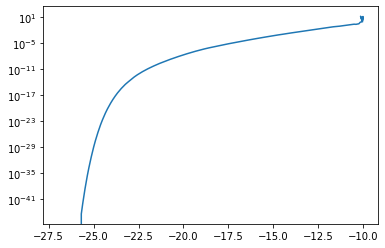

In [12]:
LF_tab = load_uvf_pandas(LFz_files[6]) #load in UV LF files, index 6 = z 6.8
plt.semilogy(LF_tab['Muv'],LF_tab['ndens'])

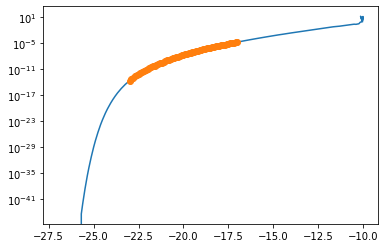

In [13]:
#Interpolating UV LF Muv and ndens values into a 1d array
LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
new_ndens = LF_interp(Muv_EW) #for new x=Muv_EW, y=new_ndens
#multiplying same thing at same Muv value -- UV LF at same Muv val as EW distribution = new_ndens


plt.semilogy(LF_tab['Muv'],LF_tab['ndens']) #UV LF values (181 Muv vals)
plt.plot(Muv_EW,new_ndens,'o') #EW Values along UV LF plot (61 Muv vals)
#Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 


In [14]:
#print(jacobian) #this is a 1D array
#For loop, regarding xHI and Muv in EW
xHI_array = np.array([0.01])

for xx,xHI in enumerate (xHI_tab): #for each index and corresponding xHI value in list of xHI, call specific data file
    if xHI in xHI_array:
        pW_tab = load_uvf_pandas(pW_files[xx])
        for mm, Muv in enumerate(Muv_EW):
            jacobian_new = pd.DataFrame(jacobian) ##Transpose this dataframe
            EW_vals = pd.DataFrame([pW_tab[f'{Muv}']])
#             pLya = jacobian_new * EW_vals
#             print(EW_vals.ndim)

# print(EW_vals.shape)

NameError: name 'jacobian' is not defined

In [15]:
rows, cols = (5, 5) 
arr = np.array([[0]*cols]*rows)
print(arr.shape) 

(5, 5)
